# Word2Vec and BERT Model Training and Comparison (version 2)

## Objective
This script preprocesses three corpora (BNC, FCL, Legislation), trains Word2Vec and BERT models,
evaluates them using synonym similarity, and analses semantic shifts across corpora.
It includes corpus pre-processing, semantic shift analysis, and three
semantic search prototypes: Word2Vec based, and 2 BERT based protoypes (1 with keyword detection).


In [4]:
# Import Libraries
import spacy, time, requests, os, itertools, json, re, pickle, torch, itertools, nltk
from gensim.models import Word2Vec
from gensim.matutils import unitvec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup
from scipy.spatial.distance import cosine
from statistics import mean
from collections import Counter
from html import unescape
from tqdm import tqdm
from scipy.spatial.distance import cosine, euclidean
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# STEP 1: Corpus preprocessing 

In [9]:
# Load spaCy Model
nlp = spacy.load("en_core_web_sm")

In [ ]:
def clean_text(text):
    # Remove XML tags using BeautifulSoup
    clean_text = BeautifulSoup(text, "html.parser").get_text()
    
    # Split words where lowercase is followed by uppercase
    clean_text = re.sub(r'([a-z])([A-Z])', r'\1 \2', clean_text)

    # Additional cleaning: normalize whitespace
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()

    return clean_text

In [ ]:
def process_text_in_chunks(text, chunk_size=100_000, min_token_length=3, stoplist=None):
    """Function to process text in manageable chunks, with better handling of tokens."""
    if stoplist is None:
        stoplist = set()

    # First clean the text to fix concatenation issues
    text = clean_text(text)
    
    tokens = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i + chunk_size].lower()
        doc = nlp(chunk)
        
        # Add lemmatized tokens while filtering out unwanted tokens
        chunk_tokens = []
        for token in doc:
            # Only include proper tokens
            if (token.is_alpha and 
                not token.is_stop and 
                len(token.text) >= min_token_length and
                token.lemma_.lower() not in stoplist):
                
                # Additional check for concatenated words that might have been missed
                lemma = token.lemma_.lower()
                if re.search(r'[a-z][A-Z]', lemma):
                    # Skip concatenated words that weren't properly split
                    continue
                    
                chunk_tokens.append(lemma)
                
        tokens.extend(chunk_tokens)
    
    return tokens

In [ ]:
# Stoplist of terms to filter out
stoplist = {
    "listitem", 'itemlistelement', 'breadcrumblist', "legaldocml", "xml", 
    "pdf", "doc", "download", "govuk", "http", "https", "www", "html", 
    "paragraph", "section", "subsection", "appendix",
    "page", "footnote", "endnote", "header", "footer",
    "anor", "ewhc", "fam", "lawbeta", "nomodule", "frontend"}

### Find Case Law corpus (EWHC Family division)
Call Find Case Law API, information here: https://nationalarchives.github.io/ds-find-caselaw-docs/public

In [ ]:
# loading FCL corpus from API
api_url = "https://caselaw.nationalarchives.gov.uk/ewhc/fam/atom.xml"

In [ ]:
#configuration API settings
total_pages = 58 # Total number of pages
per_page = 50    # Number of cases per page
delay = 1         # Delay between requests to avoid rate limiting

In [ ]:
# Improved FCL data collection with better error handling and preprocessing
fcl_data = []
for page in range(1, total_pages + 1):
    print(f"Fetching page {page} of {total_pages}...")

    try:
        response = requests.get(api_url, params={'page': page, 'per_page': per_page, 'order': '-date'})
        response.raise_for_status()  # Raise exception for HTTP errors
        
        soup = BeautifulSoup(response.text, "xml")
        for entry in soup.find_all("entry"):
            try:
                case_link = entry.find("link", {"rel": "alternate"})["href"]
                case_response = requests.get(case_link)
                case_response.raise_for_status()

                case_text = BeautifulSoup(case_response.text, "xml").get_text()
                processed_text = process_text_in_chunks(case_text, stoplist=stoplist)
                
                # Additional validation to ensure quality
                if processed_text and len(processed_text) > 50:  # Ensure we have enough tokens
                    fcl_data.append(processed_text)
            except Exception as e:
                print(f"Error processing case: {e}")
    except Exception as e:
        print(f"Error fetching page {page}: {e}")

    time.sleep(delay)  # Avoid overwhelming the server

In [ ]:
#save corpus to json file
with open("/Users/caitlinwilson/Scripts_Local/fcl_fam_corpus_spacy_v3.json", 'w', encoding='utf-8') as f:
    json.dump(fcl_data, f, ensure_ascii=False, indent=2)

In [5]:
#load again
with open("/Users/caitlinwilson/Scripts_Local/fcl_fam_corpus_spacy_v3.json", 'r', encoding='utf-8') as f:
    fcl_data = json.load(f)

In [3]:
print(fcl_data[:5])

[['find', 'case', 'law', 'national', 'archive', 'enable', 'module', 'htmlscript', 'support', 'website', 'use', 'cookie', 'place', 'essential', 'cookie', 'device', 'website', 'work', 'like', 'use', 'additional', 'cookie', 'remember', 'setting', 'understand', 'use', 'service', 'information', 'help', 'improvement', 'website', 'set', 'cookie', 'preference', 'skip', 'main', 'content', 'find', 'case', 'law', 'beta', 'judgment', 'decision', 'menu', 'home', 'help', 'guidance', 'breadcrumb', 'list', 'item', 'list', 'element', 'list', 'item', 'position', 'find', 'case', 'law', 'item', 'list', 'item', 'position', 'find', 'case', 'law', 'research', 'improve', 'find', 'case', 'law', 'service', 'view', 'option', 'neutral', 'citation', 'number', 'high', 'court', 'justicefamily', 'divisionroyal', 'court', 'justice', 'strand', 'london', 'april', 'justice', 'vand', 'amy', 'proudman', 'instruct', 'direct', 'access', 'appellant', 'carl', 'geary', 'instruct', 'mitchell', 'ryan', 'solicitors', 'respondent',

### British National Corpus
Save XMl files locally from http://www.natcorp.ox.ac.uk/XMLedition/

In [ ]:
def load_and_preprocess_bnc(directory, stoplist=None, verbose=False):
    bnc_data = []

    # Collect all XML file paths first
    xml_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".xml"):
                xml_files.append(os.path.join(root, file))

    print(f"Found {len(xml_files)} BNC XML files. Starting processing...\n")

    for file_path in tqdm(xml_files, desc="Processing BNC files", unit="file"):
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()

            processed_text = process_text_in_chunks(content, stoplist=stoplist)

            if processed_text and len(processed_text) > 50:
                bnc_data.append(processed_text)

        except Exception as e:
            if verbose:
                print(f"⚠️ Error processing {file_path}: {e}")

    print(f"\n✅ Finished loading BNC. Loaded {len(bnc_data)} valid documents.\n")
    return bnc_data


In [ ]:
bnc_directory = "/Users/caitlinwilson/Scripts_Local/BNC xml"
bnc_data = load_and_preprocess_bnc(bnc_directory, stoplist=stoplist, verbose=True)

In [ ]:
#save to file
with open("/Users/caitlinwilson/Scripts_Local/bnc_corpus_spacy_v3.json", 'w', encoding='utf-8') as f:
    json.dump(bnc_data, f, ensure_ascii=False, indent=2)

In [ ]:
print(bnc_data[:5])

In [3]:
#load again
with open("/Users/caitlinwilson/Scripts_Local/bnc_corpus_spacy_v3.json", 'r', encoding='utf-8') as f:
    bnc_data = json.load(f)

### Legislation
Bulk download files from research.legislation.gov.uk here I downloaded only e-published UK Public General Acts from 2000 to 2025 in Akoma Ntoso format.

In [ ]:
def load_and_preprocess_legislation(directory):
    corpus = []

    # Get all .akn files directly from the specified directory
    akn_files = [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.endswith(".akn")
    ]

    print(f"Found {len(akn_files)} AKN files in {directory}. Starting processing...\n")

    for i, file_path in enumerate(tqdm(akn_files, desc="Processing files")):
        print(f"\n{i+1}/{len(akn_files)}) Processing: {file_path}")

        with open(file_path, "r", encoding="utf-8") as f:
            soup = BeautifulSoup(f.read(), "xml")

            # Extract text from <p> tags
            paragraphs = [p.get_text() for p in soup.find_all("p")]
            text = " ".join(paragraphs)

            # Process text in chunks
            tokenized_sentences = process_text_in_chunks(text)
            corpus.extend(tokenized_sentences)

    print("\nProcessing complete!")
    return corpus

leg_directory = "/Users/caitlinwilson/Scripts_Local/leg_enacted_ukgpa_2000-2025"
leg_data = load_and_preprocess_legislation(leg_directory)

In [ ]:
print(leg_data[:10])

In [ ]:
#save to file
with open("/Users/caitlinwilson/Scripts_Local/leg_ukgpa_corpus_spacy.json", 'w', encoding='utf-8') as f:
    json.dump(leg_data, f, ensure_ascii=False, indent=2)

In [4]:
with open("/Users/caitlinwilson/Scripts_Local/leg_ukgpa_corpus_spacy.json", 'r') as f:
    leg_data = json.load(f)

## Corpus statistics

In [ ]:
def get_corpus_stats(corpus):
    # Flatten the list of lists into a single list of tokens
    tokens = list(itertools.chain(*corpus))  # Flatten the list of lists
    num_tokens = len(tokens)
    num_types = len(set(tokens))
    type_token_ratio = num_types / num_tokens if num_tokens > 0 else 0
    freq_dist = Counter(tokens)
    most_common_words = freq_dist.most_common(10)
    
    # Return stats as a dictionary
    return {
        "Total Tokens": num_tokens,
        "Unique Types": num_types,
        "Type-Token Ratio (TTR)": round(type_token_ratio, 4),
        "Most Common Words": most_common_words
    }

In [ ]:
# Get stats for the FCL corpus
fcl_stats = get_corpus_stats(fcl_data)
bnc_stats = get_corpus_stats(bnc_data)
leg_stats = get_corpus_stats(leg_data)

In [ ]:
# Print the FCL corpus stats
print("FCL Corpus Statistics:")
for key, value in fcl_stats.items():
    print(f"{key}: {value}")

In [ ]:
# Print the BNC corpus stats
print("BNC Corpus Statistics:")
for key, value in bnc_stats.items():
    print(f"{key}: {value}")

In [ ]:
# Print the Leg corpus stats
print("Leg Corpus Statistics:")
for key, value in leg_stats.items():
    print(f"{key}: {value}")

# STEP 2a: Word2Vec Model Training

In [ ]:
# Define hyperparameter ranges for Word2Vec models
vector_sizes = [300, 1000] 
windows = [5, 10]
min_counts = [5]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram

In [ ]:
# Store models and names
fcl_models = []
fcl_model_names = []
bnc_models = []
bnc_model_names = []
leg_models = []
leg_model_names = []

In [ ]:
# Folder to save models
models_folder = "/Users/caitlinwilson/Scripts_Local/w2v_models_improved" 
os.makedirs(models_folder, exist_ok=True) 

In [ ]:
# Improved model training with better parameters
def train_word2vec_models(corpus_data, corpus_name, vector_sizes, windows, min_counts, sg_values):
    """Train multiple Word2Vec models with different hyperparameters."""
    models = []
    model_names = []
    
    for vector_size in vector_sizes:
        for window in windows:
            for min_count in min_counts:
                for sg in sg_values:
                    # Generate model name
                    model_type = "cbow" if sg == 0 else "sg"
                    model_name = f"{corpus_name}_{model_type}_w{window}_f{min_count}_{vector_size}_v3"

                    # Train model with more epochs and better parameters
                    model = Word2Vec(
                        corpus_data, 
                        min_count=min_count, 
                        vector_size=vector_size, 
                        window=window, 
                        sg=sg,
                        epochs=10,  # Increased from default 5
                        workers=4   # Use multiple cores
                    )

                    # Save model in list
                    models.append(model)
                    model_names.append(model_name)

                    # Save model to folder
                    model_path = os.path.join(models_folder, f"{model_name}.bin")
                    model.save(model_path)

                    print(f"Saved model: {model_name}.bin")
                    
    return models, model_names

# Uncomment to train models
fcl_models, fcl_model_names = train_word2vec_models(fcl_data, "fcl_fam", vector_sizes, windows, min_counts, sg_values)
bnc_models, bnc_model_names = train_word2vec_models(bnc_data, "bnc", vector_sizes, windows, min_counts, sg_values)

# STEP 2b: Fine-tuning BERT on FCL
Finetuning done on Google collab as kept timing out on my machine -- cells copied below for record.

In [ ]:
import os, shutil, json
from datasets import Dataset
from google.colab import files
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
#load FCL corpus
with open("fcl_fam_corpus_spacy_v3.json", "r") as f:
    fcl_data = json.load(f)

# ensure data prepared
fcl_texts = [" ".join(doc) for doc in fcl_data[:1000]]  # limit for safe training
fcl_dataset = Dataset.from_dict({"text": fcl_texts})

In [ ]:
#load BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

#tokenize texts
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=64)

tokenized_fcl = fcl_dataset.map(tokenize_function, batched=True)

In [ ]:
#use data collector for masked language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

#set training arguments
training_args = TrainingArguments(
    output_dir="./fcl_bert_model",
    eval_strategy="no",
    per_device_train_batch_size=2,
    num_train_epochs=2,
    max_steps=100,
    save_steps=50,
    save_total_limit=1,
    logging_steps=10,
    fp16=False,
    report_to="none"
)

In [ ]:
#train model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_fcl,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

In [ ]:
#save model
model.save_pretrained("./fcl_bert_model")
tokenizer.save_pretrained("./fcl_bert_model")

# zip and download
shutil.make_archive("fcl_bert_model", 'zip', "./fcl_bert_model")
files.download("fcl_bert_model.zip")

### now to load the embeddings we created

In [2]:
from transformers import BertTokenizer, BertModel

# Load the tokenizer and model
model_dir = "./fcl_bert_model"  

tokenizer = BertTokenizer.from_pretrained(model_dir)
model = BertModel.from_pretrained(model_dir)
model.eval()  # set model to evaluation mode

Some weights of BertModel were not initialized from the model checkpoint at ./fcl_bert_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
from collections import defaultdict
import numpy as np

lemma_embeddings = defaultdict(list)

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Aggregate embeddings per lemma
for doc in fcl_data:
    for lemma in doc:
        embedding = get_embedding(lemma)
        lemma_embeddings[lemma].append(embedding)

# Average across all embeddings per lemma
fcl_word_embeddings = {
    lemma: np.mean(embeds, axis=0)
    for lemma, embeds in lemma_embeddings.items()
}


In [ ]:
import pickle

with open('/Users/caitlinwilson/Scripts_Local/fcl_bert_finetuned_embeddings.pkl', 'wb') as f:
    pickle.dump(fcl_word_embeddings, f)

# now with BNC (generate embeddings from all-mpnet-base-v2)

In [5]:
# Load a BERT model
bert_model = SentenceTransformer('all-mpnet-base-v2')  

In [56]:
# Improved approach: Create word-level embeddings instead of document-level
def create_word_embeddings(model, vocabulary):
    """Create embeddings for individual words rather than entire documents."""
    print(f"Creating embeddings for {len(vocabulary)} words...")
    word_embeddings = {}
    
    # Process in batches to avoid memory issues
    batch_size = 128
    for i in range(0, len(vocabulary), batch_size):
        batch = vocabulary[i:i+batch_size]
        embeddings = model.encode(batch, show_progress_bar=False)
        
        for word, embedding in zip(batch, embeddings):
            word_embeddings[word] = embedding
            
        if i % 1000 == 0:
            print(f"Processed {i}/{len(vocabulary)} words")
    
    return word_embeddings

In [58]:
# Extract vocabulary from corpora
def extract_vocabulary(corpus_data, min_length=3, max_length=20):
    vocabulary = set()
    
    for document in corpus_data:
        for token in document:
            # Apply filtering to ensure quality vocabulary
            if (len(token) >= min_length and 
                len(token) <= max_length and
                token.isalpha()):
                vocabulary.add(token)
    
    return list(vocabulary)

# Extract vocabularies
bnc_vocabulary = extract_vocabulary(bnc_data)

print(f"BNC vocabulary size: {len(bnc_vocabulary)}")

FCL vocabulary size: 52126
BNC vocabulary size: 307521


In [ ]:
# Create word embeddings for both corpora

bnc_bert_embeddings = create_word_embeddings(bert_model, bnc_vocabulary)

# Save embeddings using pickle
with open('/Users/caitlinwilson/Scripts_Local/bnc_bert_embeddings.pkl', 'wb') as f:
    pickle.dump(bnc_bert_embeddings, f)

In [8]:
# Load previsouly saved embeddings  
with open('/Users/caitlinwilson/Scripts_Local/bnc_bert_embeddings.pkl', 'rb') as f:
    bnc_bert_embeddings = pickle.load(f)

print(f"Loaded {len(bnc_bert_embeddings)} BNC word embeddings")

Loaded 52126 FCL word embeddings
Loaded 307521 BNC word embeddings


# STEP 3: finding best model for each corpus using similarity scores

In [ ]:
# Load SimLex-999 Data
simlex_path = "SimLex-999.txt"
simlex_df = pd.read_csv(simlex_path, delimiter='\t')

In [ ]:
# Extract synonym pairs (where SimLex-999 similarity score is high)
simlex_synonyms = {row['word1']: row['word2'] for _, row in simlex_df.iterrows() if row['SimLex999'] >= 8.0}

In [ ]:
# We can also define domain specific sysnonyms if wanted
synonyms_fcl = {
    'contract': 'agreement',
    'plaintiff': 'claimant',
    'defendant': 'respondent',
    'liable': 'responsible',
    'damages': 'compensation',
    'breach': 'violation',
    'negligence': 'carelessness',
    'fraud': 'deception',
    'precedent': 'authority',
    'statute': 'legislation'
}

In [ ]:
# Model Evaluation Using SimLex-999 or FCL synonyms
def evaluate_models_with_synonyms(models, synonym_dict):
    models_synonymity_average = {}
    
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        synonymities = []
        
        for word1, word2 in synonym_dict.items():
            if word1 in model.wv and word2 in model.wv:
                similarity = 1 - cosine(model.wv[word1], model.wv[word2])
                synonymities.append(similarity)
                print(f"\tSimilarity between '{word1}' and '{word2}' in {model_name}: {similarity:.4f}")
        
        avg_synonymity = mean(synonymities) if synonymities else 0
        print(f"Average synonym similarity for {model_name}: {avg_synonymity:.4f}\n")
        models_synonymity_average[model_name] = avg_synonymity
    
    return models_synonymity_average

In [ ]:
# Load all .bin models from folder
fcl_models = {}
for file in os.listdir(models_folder):
    if file.startswith("fcl") and file.endswith("v2.bin"):
        model_path = os.path.join(models_folder, file)
        model = Word2Vec.load(model_path)
        fcl_models[file] = model

In [ ]:
fcl_models = {}
bnc_models = {}
leg_models = {}

for file in os.listdir(models_folder):
    model_path = os.path.join(models_folder, file)
    
    if file.startswith("fcl") and file.endswith("v3.bin"):
        fcl_models[file] = Word2Vec.load(model_path)
    elif file.startswith("bnc") and file.endswith("v3.bin"):
        bnc_models[file] = Word2Vec.load(model_path)
    elif file.startswith("leg") and file.endswith(".bin"):
        leg_models[file] = Word2Vec.load(model_path)

In [ ]:
print(f"Loaded {len(fcl_models)} FCL models")
print(f"Loaded {len(bnc_models)} BNC models")
print(f"Loaded {len(leg_models)} LEG models")

In [ ]:
# Evaluation
scores_leg = evaluate_models_with_synonyms(leg_models, simlex_synonyms)
scores_bnc = evaluate_models_with_synonyms(bnc_models, simlex_synonyms)
scores_fcl = evaluate_models_with_synonyms(fcl_models, simlex_synonyms)

In [ ]:
# Select the Best Model
def select_best_model(models, scores):
    if not scores:
        raise ValueError("No scores were provided. Make sure you've evaluated your models.")
    best_model_name = max(scores, key=scores.get)
    print(f"Best model: {best_model_name} with score {scores[best_model_name]:.4f}")
    return models[best_model_name]

In [ ]:
best_bnc_model = select_best_model(bnc_models, scores_bnc)
best_fcl_model = select_best_model(fcl_models, scores_fcl)
best_leg_model = select_best_model(leg_models, scores_leg)

In [4]:
# Load previously trained models
best_bnc_model = Word2Vec.load("/Users/caitlinwilson/Scripts_Local/w2v_models_improved/bnc_sg_w10_f5_300_v3.bin")
best_fcl_model = Word2Vec.load("/Users/caitlinwilson/Scripts_Local/w2v_models_improved/fcl_fam_sg_w5_f5_300_v3.bin")
best_leg_model = Word2Vec.load("/Users/caitlinwilson/Scripts_Local/w2v_models_improved/leg_ukgpa_sg_w5_f0_300_spacy.bin")

# Quick validation check
print("Word2Vec Model Validation:")
print("\nFCL model similar to 'parent':")
print(best_fcl_model.wv.most_similar("parent", topn=10))

print("\nBNC model similar to 'parent':")
print(best_bnc_model.wv.most_similar("parent", topn=10))

print("\nLeg model similar to 'parent':")
print(best_leg_model.wv.most_similar("parent", topn=10))

print("\nSimilarity between 'court' and 'judge' in FCL:", best_fcl_model.wv.similarity("court", "judge"))
print("Similarity between 'parent' and 'guardian' in FCL:", best_fcl_model.wv.similarity("parent", "guardian"))

Word2Vec Model Validation:

FCL model similar to 'parent':
[('mother', 0.6375865340232849), ('father', 0.5963670611381531), ('child', 0.5188376903533936), ('gone', 0.5125077366828918), ('adoptable', 0.5042281746864319), ('emm', 0.4985440671443939), ('wholehearte', 0.49479126930236816), ('inadvisable', 0.48462730646133423), ('adoptee', 0.48376399278640747), ('parental', 0.47618064284324646)]

BNC model similar to 'parent':
[('child', 0.7496333122253418), ('mother', 0.6670418381690979), ('parental', 0.6527970433235168), ('family', 0.6355932950973511), ('sibling', 0.6106365323066711), ('adoptive', 0.6012600660324097), ('kocanek', 0.6001402735710144), ('familymaker', 0.5946572422981262), ('stepmum', 0.5932161211967468), ('abusing', 0.5871391296386719)]

Leg model similar to 'parent':
[('adoptive', 0.6172351837158203), ('stepsister', 0.5802983045578003), ('cousin', 0.5785818099975586), ('stepbrother', 0.5771670937538147), ('stepdaughter', 0.5766158103942871), ('forebear', 0.5644339323043823

# STEP 4: Semantic Shift comparison

### Semantic shift calculcated with Word2Vec embeddings

In [ ]:
def get_nearest_neighbors_w2v(word, model, k=10):
    if word not in model.wv.index_to_key:
        return []
    return model.wv.most_similar(word, topn=k)
    
def create_shift_table_w2v(word_list, fcl_model, bnc_model, k=5):
    rows = []

    for word in word_list:
        if word not in fcl_model.wv:
            continue

        fcl_neighbors = get_nearest_neighbors_w2v(word, fcl_model, k)
        bnc_neighbors = get_nearest_neighbors_w2v(word, bnc_model, k)

        fcl_display = ", ".join([f"{w} ({s:.2f})" for w, s in fcl_neighbors])
        bnc_display = ", ".join([f"{w} ({s:.2f})" for w, s in bnc_neighbors])

        rows.append({
            "Word": word,
            "Legal Nearest Neighbors (FCL)": fcl_display,
            "General Nearest Neighbors (BNC)": bnc_display
        })

    return pd.DataFrame(rows)

In [ ]:
# For Word2Vec
w2v_shift_table = create_shift_table_w2v(words_list, best_fcl_model, best_bnc_model)
print("\n--- Word2Vec Semantic Shift Table ---\n")
print(w2v_shift_table)

### Semantic shift calculated with BERT embeddings

In [12]:
with open("fcl_word_embeddings_finetuned.pkl", "rb") as f:
    fcl_embeddings = pickle.load(f)

with open("bnc_bert_embeddings.pkl", "rb") as f:
    bnc_embeddings = pickle.load(f)

shared_vocab = list(set(fcl_embeddings.keys()) & set(bnc_embeddings.keys()))
print(f"Shared vocabulary size: {len(shared_vocab)}")

rows = []

for word in shared_vocab:
    vec_fcl = fcl_embeddings[word]
    vec_bnc = bnc_embeddings[word]

    cos_sim = cosine_similarity([vec_fcl], [vec_bnc])[0][0]
    shift_score = 1 - cos_sim  # Higher = more shift

    rows.append({
        "word": word,
        "cosine_similarity": cos_sim,
        "semantic_shift": shift_score
    })

shift_df = pd.DataFrame(rows).sort_values(by="semantic_shift", ascending=False)
shift_df.head(10)

Shared vocabulary size: 38004


,word,cosine_similarity,semantic_shift
9504,primarolo,-0.153305,1.153305
32967,ruanne,-0.150907,1.150907
37648,lining,-0.138265,1.138265
36431,deficit,-0.136254,1.136254
20554,rutledge,-0.134709,1.134709
5886,facia,-0.134635,1.134635
33837,boyle,-0.133547,1.133547
36957,nicolas,-0.132020,1.132020
15141,royle,-0.130920,1.130920
26324,burglar,-0.127789,1.127789


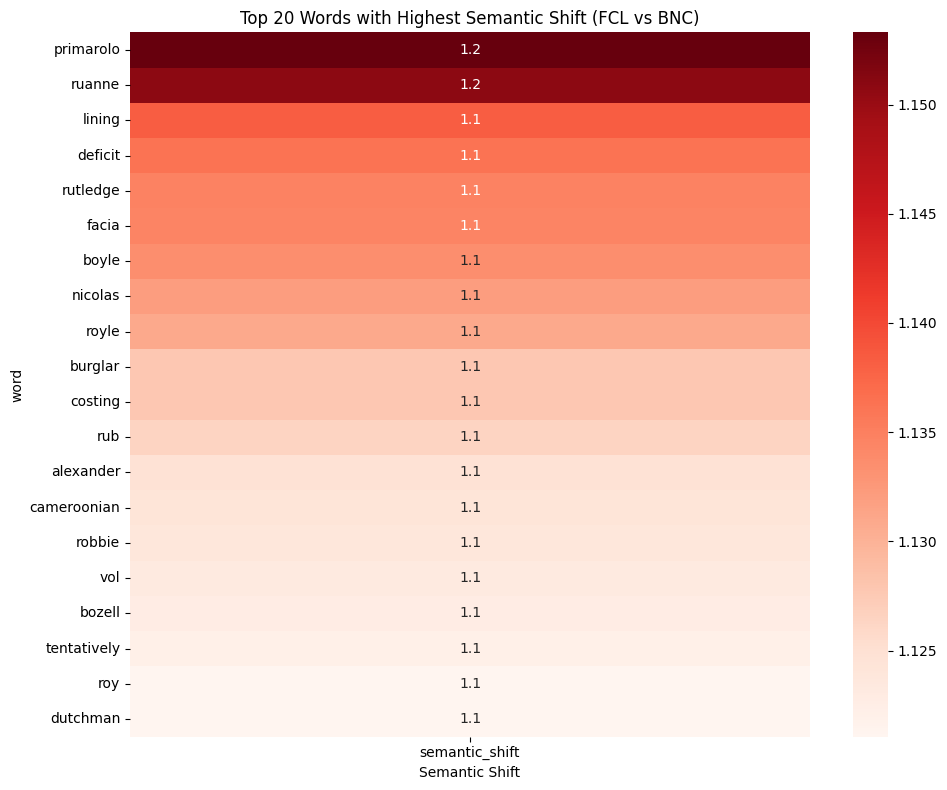

In [13]:
top_words = shift_df.head(20).set_index("word")

plt.figure(figsize=(10, 8))
sns.heatmap(top_words[["semantic_shift"]], cmap="Reds", annot=True)
plt.title("Top 20 Words with Highest Semantic Shift (FCL vs BNC)")
plt.xlabel("Semantic Shift")
plt.tight_layout()
plt.show()


# STEP 5: Semantic Search Implementation

## Word2Vec-based Semantic Search

In [5]:
def extract_keyword_w2v(sentence, model):
    doc = nlp(sentence)
    
    # Lemmatize and keep content words (nouns, verbs, adjectives)
    content_words = [token.lemma_.lower() for token in doc if token.pos_ in ['NOUN', 'VERB', 'ADJ']]

    if not content_words:
        return None

    # Only keep words that are actually in the Word2Vec vocab
    valid_words = [word for word in content_words if word in model.wv]

    if not valid_words:
        return None

    # Find the most "central" word: highest average similarity to others
    sims = []
    for word in valid_words:
        other_words = [w for w in valid_words if w != word]
        if not other_words:
            avg_sim = 0
        else:
            avg_sim = np.mean([model.wv.similarity(word, other) for other in other_words])
        sims.append(avg_sim)

    best_word = valid_words[np.argmax(sims)]
    return best_word

def suggest_search_terms_w2v(word, fcl_model, bnc_model, k=5, threshold=0.5):
    if word not in fcl_model.wv:
        return f"'{word}' not found in the legal corpus. Try another term."

    # Get nearest neighbors from FCL model with scores
    fcl_neighbors = fcl_model.wv.most_similar(word, topn=k*5)  # pull extra, we'll filter

    filtered_neighbors = []
    for neighbor, score in fcl_neighbors:
        if score < threshold:
            continue
        if not neighbor.isalpha() or len(neighbor) < 3 or len(neighbor) > 20:
            continue
        if neighbor.startswith(word) or word.startswith(neighbor):
            if abs(len(neighbor) - len(word)) <= 2:
                continue
        if neighbor in bnc_model.wv:
            bnc_similarity = bnc_model.wv.similarity(word, neighbor)
            if score > bnc_similarity or bnc_similarity < 0.4:
                filtered_neighbors.append((neighbor, score))
        else:
            filtered_neighbors.append((neighbor, score))

    filtered_neighbors.sort(key=lambda x: x[1], reverse=True)
    top_neighbors = filtered_neighbors[:k]

    if not top_neighbors:
        return f"No distinctive legal terms found for '{word}'. Try another term."

    result_terms = [f"{term} ({score:.2f})" for term, score in top_neighbors]
    return f"Suggested legal search terms for '{word}': {', '.join(result_terms)}"

In [6]:
def semantic_search_engine_w2v():
    print("Semantic Search Engine (Word2Vec)")
    print("Type a word to find legal-specific related terms. Type 'exit' to quit.\n")

    while True:
        user_input = input("Enter a word: ").strip().lower()
        if user_input == 'exit':
            break
        print(suggest_search_terms_w2v(user_input, best_fcl_model, best_bnc_model))
        print()

In [10]:
def semantic_suggestions_w2v():
    print("Semantic Suggestions (Word2Vec)")
    print("Type a sentence to find legal-specific related terms. Type 'exit' to quit.\n")

    while True:
        user_input = input("Enter a sentence: ").strip()
        if user_input.lower() == 'exit':
            break
        keyword = extract_keyword_w2v(user_input, best_fcl_model)

        if not keyword:
            print("Couldn't extract meaningful keyword. Try rephrasing.")
            continue

        print(f"\nDetected keyword: {keyword}")
        print(suggest_search_terms_w2v(keyword, best_fcl_model, best_bnc_model))
        print()

In [11]:
semantic_suggestions_w2v()

Semantic Suggestions (Word2Vec)
Type a sentence to find legal-specific related terms. Type 'exit' to quit.



Enter a sentence:  debt



Detected keyword: debt
Suggested legal search terms for 'debt': indebtedness (0.65), liability (0.64), loan (0.62), overdraft (0.59), unsecured (0.57)



Enter a sentence:  partner



Detected keyword: partner
No distinctive legal terms found for 'partner'. Try another term.



Enter a sentence:  knife 



Detected keyword: knife
Suggested legal search terms for 'knife': screwdriver (0.62), scissor (0.60), shove (0.57), brandish (0.56), oven (0.56)



Enter a sentence:  knife crime



Detected keyword: knife
Suggested legal search terms for 'knife': screwdriver (0.62), scissor (0.60), shove (0.57), brandish (0.56), oven (0.56)



Enter a sentence:  business partner



Detected keyword: business
Suggested legal search terms for 'business': downstream (0.57), catering (0.57), tco (0.56), financier (0.55), macmillan (0.54)



Enter a sentence:  exit


In [17]:
# version 1 -- no keyword extraction

def suggest_search_terms_w2v(word, fcl_model, bnc_model, k=5, threshold=0.5):
    # Check if word exists in FCL model
    if word not in fcl_model.wv:
        return f"'{word}' not found in the legal corpus. Try another term."
    
    # Get nearest neighbors from FCL model (more than needed initially)
    fcl_neighbors = fcl_model.wv.most_similar(word, topn=50)

    # Filter neighbors based on quality criteria
    filtered_neighbors = []
    for neighbor, score in fcl_neighbors:
        if score < threshold:
            continue
        if not neighbor.isalpha() or len(neighbor) < 3 or len(neighbor) > 20:
            continue
        if neighbor.startswith(word) or word.startswith(neighbor):
            if abs(len(neighbor) - len(word)) <= 2:
                continue
        
        if neighbor in bnc_model.wv:
            bnc_similarity = bnc_model.wv.similarity(word, neighbor)
            if score > bnc_similarity or bnc_similarity < 0.4:
                filtered_neighbors.append((neighbor, score))
        else:
            filtered_neighbors.append((neighbor, score))
    
    # Sort and take the top k (default 5)
    filtered_neighbors.sort(key=lambda x: x[1], reverse=True)
    top_neighbors = filtered_neighbors[:k]
    
    if not top_neighbors:
        return f"No distinctive legal terms found for '{word}'. Try another term."
    
    # Format output
    result_terms = [f"{term} ({score:.2f})" for term, score in top_neighbors]
    return f"Suggested legal search terms for '{word}': {', '.join(result_terms)}"


In [9]:
def semantic_search_engine_w2v():
    print("Semantic Search Engine (Word2Vec)")
    print("Type a word to find legal-specific related terms. Type 'exit' to quit.\n")

    while True:
        user_input = input("Enter a word: ").strip().lower()
        if user_input == 'exit':
            break
        print(suggest_search_terms_w2v(user_input, best_fcl_model, best_bnc_model))
        print()

In [11]:
# Run the improved Word2Vec semantic search engine
semantic_search_engine_w2v()

Semantic Search Engine (Word2Vec)
Type a word to find legal-specific related terms. Type 'exit' to quit.



Enter a word:  knife crime


'knife crime' not found in the legal corpus. Try another term.



Enter a word:  exit


## BERT-based Semantic Search

In [ ]:
# version 1 -- no keyword extraction
def get_word_nearest_neighbors(word, model, word_embeddings_dict, k=10):
    if word not in word_embeddings_dict:
        return []

    word_embedding = model.encode([word])[0]
    vocab = list(word_embeddings_dict.keys())
    embeddings = np.array([word_embeddings_dict[w] for w in vocab])
    
    sims = cosine_similarity([word_embedding], embeddings)[0]
    top_k_idx = np.argsort(sims)[::-1][1:k+1]  # skip self
    return [vocab[i] for i in top_k_idx]

def suggest_search_terms(user_input):
    nn_fcl = get_word_nearest_neighbors(user_input, bert_model, fcl_word_embeddings)
    nn_bnc = get_word_nearest_neighbors(user_input, bert_model, bnc_word_embeddings)

    legal_terms = set(nn_fcl) - set(nn_bnc)

    if not legal_terms:
        return f"'{user_input}' has a shift but no clear legal alternatives. Try a broader search."

    return f"Suggested legal search terms for '{user_input}': {', '.join(legal_terms)}"

In [ ]:
def semantic_search_engine_bert():
    print("Improved Semantic Search Engine (BERT)")
    print("Type a word to find legal-specific related terms. Type 'exit' to quit.\n")

    while True:
        user_input = input("Enter a word: ").strip().lower()
        if user_input == 'exit':
            break
        print(suggest_search_terms(user_input))
        print()

In [ ]:
semantic_search_engine_bert()

## Natural Language Search Algorithm

In [39]:
def extract_key_word(sentence, model):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    content_words = [word for word, pos in tagged if pos.startswith('N') or pos.startswith('V') or pos.startswith('J')]
    if not content_words:
        return None

    sentence_emb = model.encode([sentence])[0]
    word_embeddings = model.encode(content_words)
    sims = cosine_similarity([sentence_emb], word_embeddings)[0]
    return content_words[np.argmax(sims)].lower()

def get_word_nearest_neighbors(word, model, word_embeddings_dict, k=10):
    if word not in word_embeddings_dict:
        return []

    word_embedding = model.encode([word])[0]
    vocab = list(word_embeddings_dict.keys())
    embeddings = np.array([word_embeddings_dict[w] for w in vocab])
    
    sims = cosine_similarity([word_embedding], embeddings)[0]
    top_k_idx = np.argsort(sims)[::-1][1:k+1]  # skip self
    return [vocab[i] for i in top_k_idx]

def suggest_search_terms(user_sentence):
    keyword = extract_key_word(user_sentence, bert_model)
    if not keyword:
        return "Couldn't extract a meaningful keyword. Try rephrasing."

    print(f"\nDetected keyword: '{keyword}'")

    nn_fcl = get_word_nearest_neighbors(keyword, bert_model, fcl_word_embeddings)
    nn_bnc = get_word_nearest_neighbors(keyword, bert_model, bnc_word_embeddings)

    legal_terms = set(nn_fcl) - set(nn_bnc)

    if not legal_terms:
        return f"'{keyword}' has a shift but no clear legal alternatives. Try a broader search."

    return f"Suggested legal search terms for '{keyword}': {', '.join(legal_terms)}"

In [41]:
def semantic_suggestions_bert():
    print("Semantic Search Engine (FCL vs. General English)")
    print("Type a sentence to discover legal alternatives. Type 'exit' to quit.\n")

    while True:
        user_input = input("Enter a sentence: ").strip()
        if user_input.lower() == 'exit':
            break
        print(suggest_search_terms(user_input))
        print()

In [49]:
semantic_suggestions_bert()

Semantic Search Engine (FCL vs. General English)
Type a sentence to discover legal alternatives. Type 'exit' to quit.



Enter a sentence:  knife crime



Detected keyword: 'knife'
Suggested legal search terms for 'knife': blade, sheath, dagger, stabbing, knifed, weapon, scissor, cutter, machete



Enter a sentence:  exit


# VISUALISATIONS

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def create_cosine_distance_heatmap(words, bnc_embeddings, fcl_embeddings, leg_embeddings, title="Semantic Shift Heatmap"):
    """
    Creates and plots a heatmap of cosine distances for selected words across BNC, FCL, and Legislation embeddings.

    Args:
        words: List of words to compare.
        bnc_embeddings: dict of word -> embedding (trained on BNC).
        fcl_embeddings: dict of word -> embedding (trained on FCL).
        leg_embeddings: dict of word -> embedding (trained on Legislation).
        title: Title of the plot.
    """
    data = []

    for word in words:
        if word in bnc_embeddings and word in fcl_embeddings and word in leg_embeddings:
            bnc_vec = bnc_embeddings[word]
            fcl_vec = fcl_embeddings[word]
            leg_vec = leg_embeddings[word]
            
            # Calculate cosine similarities
            sim_bnc_fcl = cosine_similarity([bnc_vec], [fcl_vec])[0][0]
            sim_bnc_leg = cosine_similarity([bnc_vec], [leg_vec])[0][0]
            sim_fcl_leg = cosine_similarity([fcl_vec], [leg_vec])[0][0]

            # Convert to distances
            dist_bnc_fcl = 1 - sim_bnc_fcl
            dist_bnc_leg = 1 - sim_bnc_leg
            dist_fcl_leg = 1 - sim_fcl_leg

            data.append([word, dist_bnc_fcl, dist_bnc_leg, dist_fcl_leg])

    # Create dataframe
    df = pd.DataFrame(data, columns=["Word", "BNC vs FCL", "BNC vs Legislation", "FCL vs Legislation"])
    df.set_index("Word", inplace=True)

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
    plt.title(title, fontsize=16)
    plt.ylabel("Word")
    plt.show()

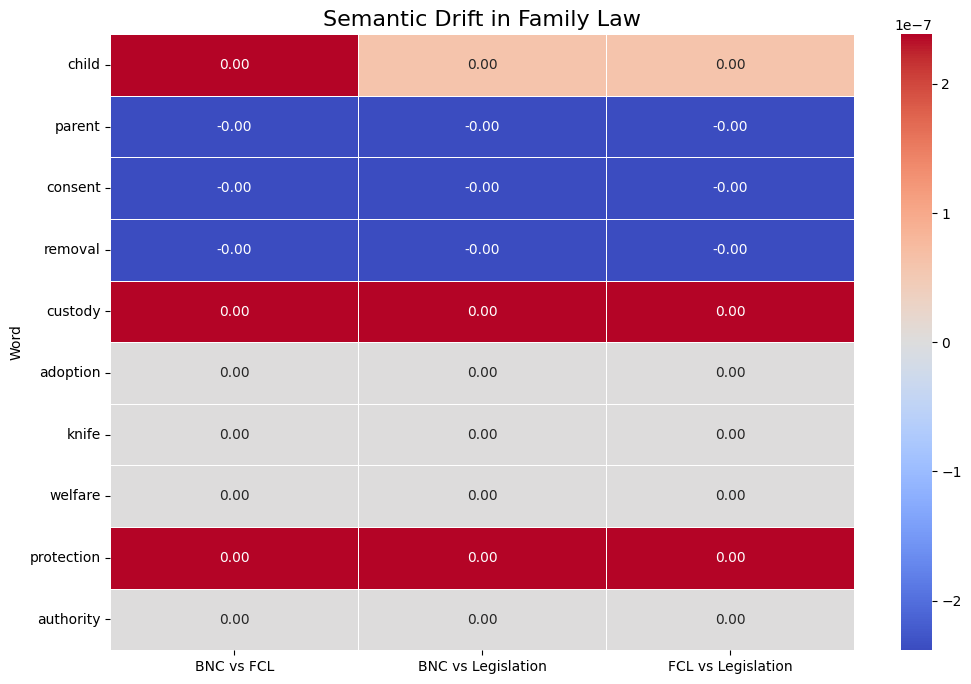

In [63]:
# Example list of words
important_words = ["child", "parent", "consent", "removal", "custody", "adoption", "knife", "welfare", "protection", "authority"]

create_cosine_distance_heatmap(
    important_words,
    bnc_word_embeddings,
    fcl_word_embeddings,
    leg_word_embeddings,
    title="Semantic Drift in Family Law"
)

In [64]:
# They must be DIFFERENT models
print(type(bnc_model))
print(type(fcl_model))
print(type(leg_model))

NameError: name 'bnc_model' is not defined

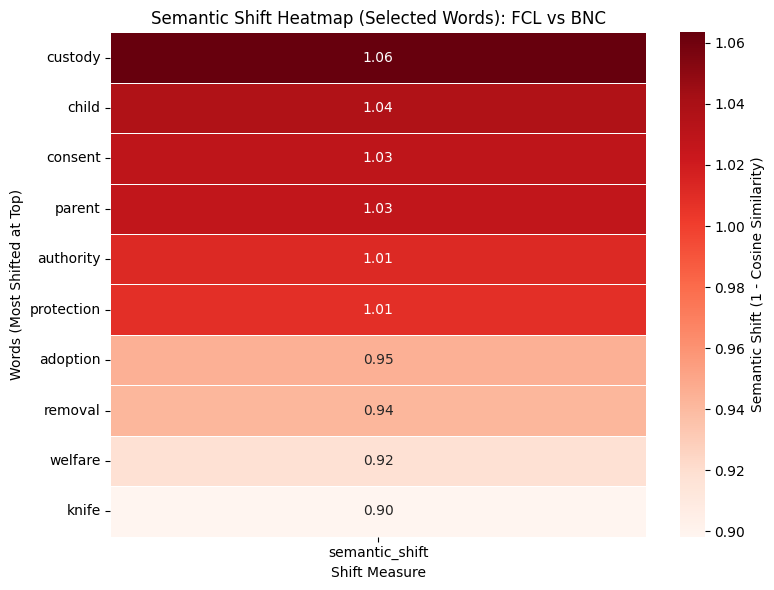

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Important words to track
important_words = ["child", "parent", "consent", "removal", "custody", 
                   "adoption", "knife", "welfare", "protection", "authority"]

# Step 1: Define a function to compute semantic shifts for selected words
def compute_semantic_shift_selected(model1, model2, selected_words):
    """Compute cosine similarity between selected words in two Word2Vec models."""
    shift_data = []

    for word in selected_words:
        if word in model1.wv and word in model2.wv:
            vec1 = model1.wv[word]
            vec2 = model2.wv[word]

            # Compute cosine similarity
            cos_sim = cosine_similarity([vec1], [vec2])[0][0]

            shift_data.append({
                "word": word,
                "cosine_similarity": cos_sim,
                "semantic_shift": 1 - cos_sim  # higher = more shift
            })
        else:
            print(f" Word '{word}' not found in both models — skipping.")

    return pd.DataFrame(shift_data)

# Step 2: Calculate semantic shifts
shift_df = compute_semantic_shift_selected(best_fcl_model, best_bnc_model, important_words)

# Step 3: Create a heatmap of the semantic shifts
plt.figure(figsize=(8, 6))

# Set 'word' as index for heatmap
heatmap_data = shift_df.set_index("word")[["semantic_shift"]]

# Plot
sns.heatmap(
    heatmap_data.sort_values(by="semantic_shift", ascending=False), 
    cmap="Reds", 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Semantic Shift (1 - Cosine Similarity)'}
)

plt.title("Semantic Shift Heatmap (Selected Words): FCL vs BNC")
plt.xlabel("Shift Measure")
plt.ylabel("Words (Most Shifted at Top)")
plt.tight_layout()
plt.show()

In [68]:
def get_neighbors_table(model1, model2, selected_words, topn=5):
    """Create a table showing nearest neighbors in two models for selected words."""
    rows = []

    for word in selected_words:
        if word in model1.wv and word in model2.wv:
            # Get topn neighbors for each model
            neighbors_model1 = [w for w, _ in model1.wv.most_similar(word, topn=topn)]
            neighbors_model2 = [w for w, _ in model2.wv.most_similar(word, topn=topn)]

            rows.append({
                "Word": word,
                "Top Neighbors in BNC": ", ".join(neighbors_model1),
                "Top Neighbors in FCL": ", ".join(neighbors_model2)
            })
        else:
            print(f" Word '{word}' not found in both models — skipping.")

    return pd.DataFrame(rows)

# Important words to track
important_words = ["child", "parent", "consent", "removal", "custody", 
                   "adoption", "knife", "welfare", "protection", "authority"]

# Create the neighbors comparison table
neighbors_df = get_neighbors_table(best_bnc_model, best_fcl_model, important_words, topn=5)

# Display the table nicely
print(neighbors_df.to_string(index=False))

# Optional: save to CSV
neighbors_df.to_csv("neighbors_comparison_bnc_fcl.csv", index=False)

      Word                                     Top Neighbors in BNC                                   Top Neighbors in FCL
     child                    parent, mother, baby, kocanek, family                    boy, parent, mother, daughter, girl
    parent                 child, mother, parental, family, sibling                 mother, father, child, gone, adoptable
   consent        impliedly, consenting, treitel, underlet, relator     eﬀective, posthumous, dispense, withdrawing, vitro
   removal remove, disfranchisement, prevent, facilitate, guidewire     retention, wrongful, remove, exercised, apposition
   custody                    remand, bail, pratley, hagans, yidana     visitation, murrow, leftbehind, exercised, vidzeme
  adoption                adopt, baaf, adopter, tunstill, fostering               aca, adopter, paraguayan, placement, agn
     knife    blade, sharpened, knifeman, knuckleduster, fornasetti            screwdriver, scissor, shove, brandish, oven
   welfare      

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_word_shift_with_neighbors(word, model1, model2, model1_name="Model1", model2_name="Model2", topn=5):
    """Improved t-SNE visualization with better labels and neighbor connections."""

    words = []
    vectors = []
    colors = []
    groups = []  # To distinguish which main word the neighbor connects to

    # Collect main word and neighbors from model1
    if word in model1.wv:
        vectors.append(model1.wv[word])
        colors.append('red')
        words.append(f"{word} ({model1_name})")
        groups.append(f"{word} ({model1_name})")

        for neighbor, _ in model1.wv.most_similar(word, topn=topn):
            vectors.append(model1.wv[neighbor])
            colors.append('pink')
            words.append(f"{neighbor} ({model1_name})")
            groups.append(f"{word} ({model1_name})")
    else:
        print(f"⚠️ Word '{word}' not found in {model1_name}")

    # Collect main word and neighbors from model2
    if word in model2.wv:
        vectors.append(model2.wv[word])
        colors.append('blue')
        words.append(f"{word} ({model2_name})")
        groups.append(f"{word} ({model2_name})")

        for neighbor, _ in model2.wv.most_similar(word, topn=topn):
            vectors.append(model2.wv[neighbor])
            colors.append('lightblue')
            words.append(f"{neighbor} ({model2_name})")
            groups.append(f"{word} ({model2_name})")
    else:
        print(f"⚠️ Word '{word}' not found in {model2_name}")

    # t-SNE projection
    n_points = len(vectors)
    perplexity = min(5, n_points - 1)  # Always perplexity < n_samples
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced = tsne.fit_transform(np.array(vectors))

    # Plot
    plt.figure(figsize=(12, 10))
    
    # First: plot the connections
    for idx, group in enumerate(groups):
        # Only draw lines for neighbor points, not the center points
        if words[idx] != group:
            center_idx = groups.index(group)
            plt.plot(
                [reduced[center_idx, 0], reduced[idx, 0]],
                [reduced[center_idx, 1], reduced[idx, 1]],
                'k-', alpha=0.2  # faint black lines
            )

    # Then: plot the points
    for idx, (x, y) in enumerate(reduced):
        if words[idx].startswith(word):
            size = 200  # larger for main word
        else:
            size = 60   # smaller for neighbors
        plt.scatter(x, y, color=colors[idx], s=size, edgecolor='k', alpha=0.9)

        # Improved labels: slightly offset + darker + background box
        plt.annotate(
            words[idx],
            (x + 1.0, y + 1.0),  # offset a bit to the top-right
            fontsize=9,
            color='black',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
        )

    plt.title(f"t-SNE: '{word}' Semantic Neighborhoods in {model1_name} and {model2_name}")
    plt.show()

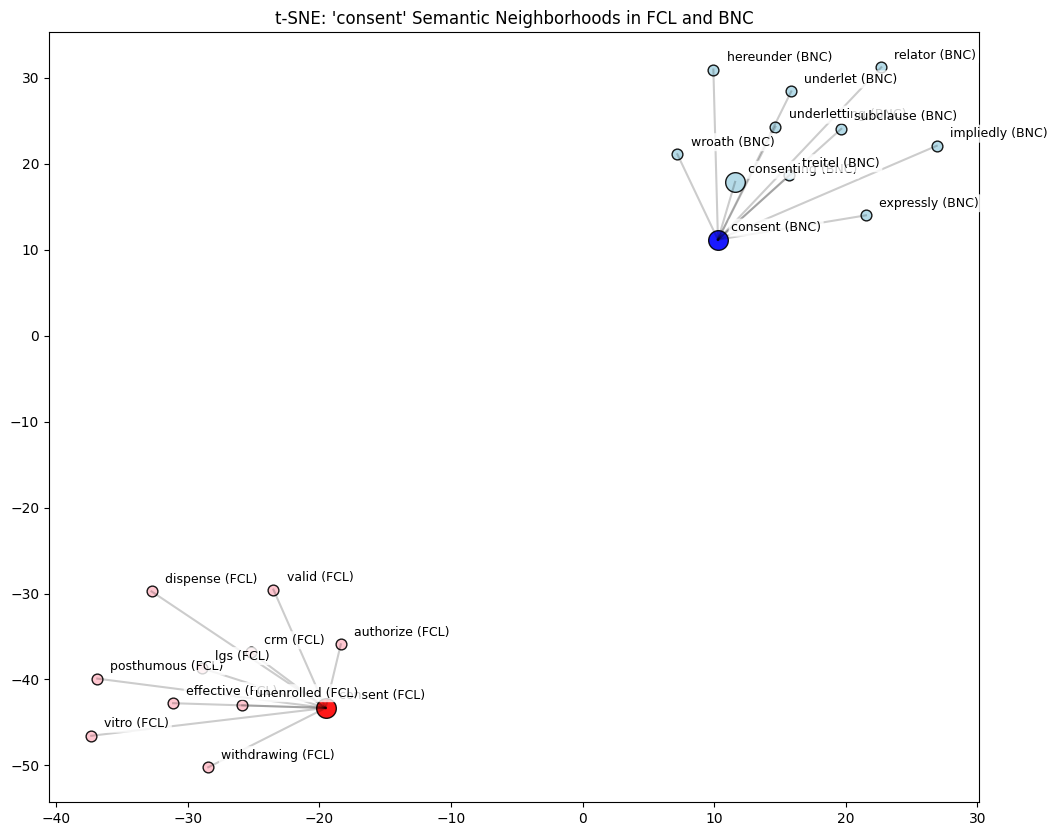

In [29]:
visualize_word_shift_with_neighbors(
    word="consent",
    model1=best_fcl_model,
    model2=best_bnc_model,
    model1_name="FCL",
    model2_name="BNC",
    topn=10
)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_multiple_words_shift_simple_colors(words_list, model1, model2, model1_name="Model1", model2_name="Model2", topn=5):
    """t-SNE visualization for multiple words with two colors only: blue (model1) and red (model2)."""

    all_words = []
    vectors = []
    colors = []
    groups = []

    for word in words_list:
        # model1: FCL (blue)
        if word in model1.wv:
            vectors.append(model1.wv[word])
            colors.append('blue')
            all_words.append(f"{word} ({model1_name})")
            groups.append(f"{word} ({model1_name})")

            for neighbor, _ in model1.wv.most_similar(word, topn=topn):
                vectors.append(model1.wv[neighbor])
                colors.append('lightblue')
                all_words.append(f"{neighbor} ({model1_name})")
                groups.append(f"{word} ({model1_name})")
        else:
            print(f"⚠️ Word '{word}' not found in {model1_name}")

        # model2: BNC (red)
        if word in model2.wv:
            vectors.append(model2.wv[word])
            colors.append('red')
            all_words.append(f"{word} ({model2_name})")
            groups.append(f"{word} ({model2_name})")

            for neighbor, _ in model2.wv.most_similar(word, topn=topn):
                vectors.append(model2.wv[neighbor])
                colors.append('pink')
                all_words.append(f"{neighbor} ({model2_name})")
                groups.append(f"{word} ({model2_name})")
        else:
            print(f"⚠️ Word '{word}' not found in {model2_name}")

    # t-SNE projection
    n_points = len(vectors)
    perplexity = min(5, n_points - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced = tsne.fit_transform(np.array(vectors))

    # Plot
    plt.figure(figsize=(14, 12))

    # Draw connecting lines
    for idx, group in enumerate(groups):
        if all_words[idx] != group:
            center_idx = groups.index(group)
            plt.plot(
                [reduced[center_idx, 0], reduced[idx, 0]],
                [reduced[center_idx, 1], reduced[idx, 1]],
                'k-', alpha=0.2
            )

    # Plot the points
    for idx, (x, y) in enumerate(reduced):
        if any(all_words[idx].startswith(w) for w in words_list):
            size = 200  # main word bigger
        else:
            size = 60   # neighbors smaller
        plt.scatter(x, y, color=colors[idx], s=size, edgecolor='k', alpha=0.9)

        plt.annotate(
            all_words[idx],
            (x + 1.0, y + 1.0),
            fontsize=9,
            color='black',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
        )

    # Add manual legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=model1_name),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=model2_name)
    ]
    plt.legend(handles=legend_elements, loc='best')

    plt.title(f"t-SNE: Semantic Shifts for {words_list} in {model1_name} and {model2_name}")
    plt.show()


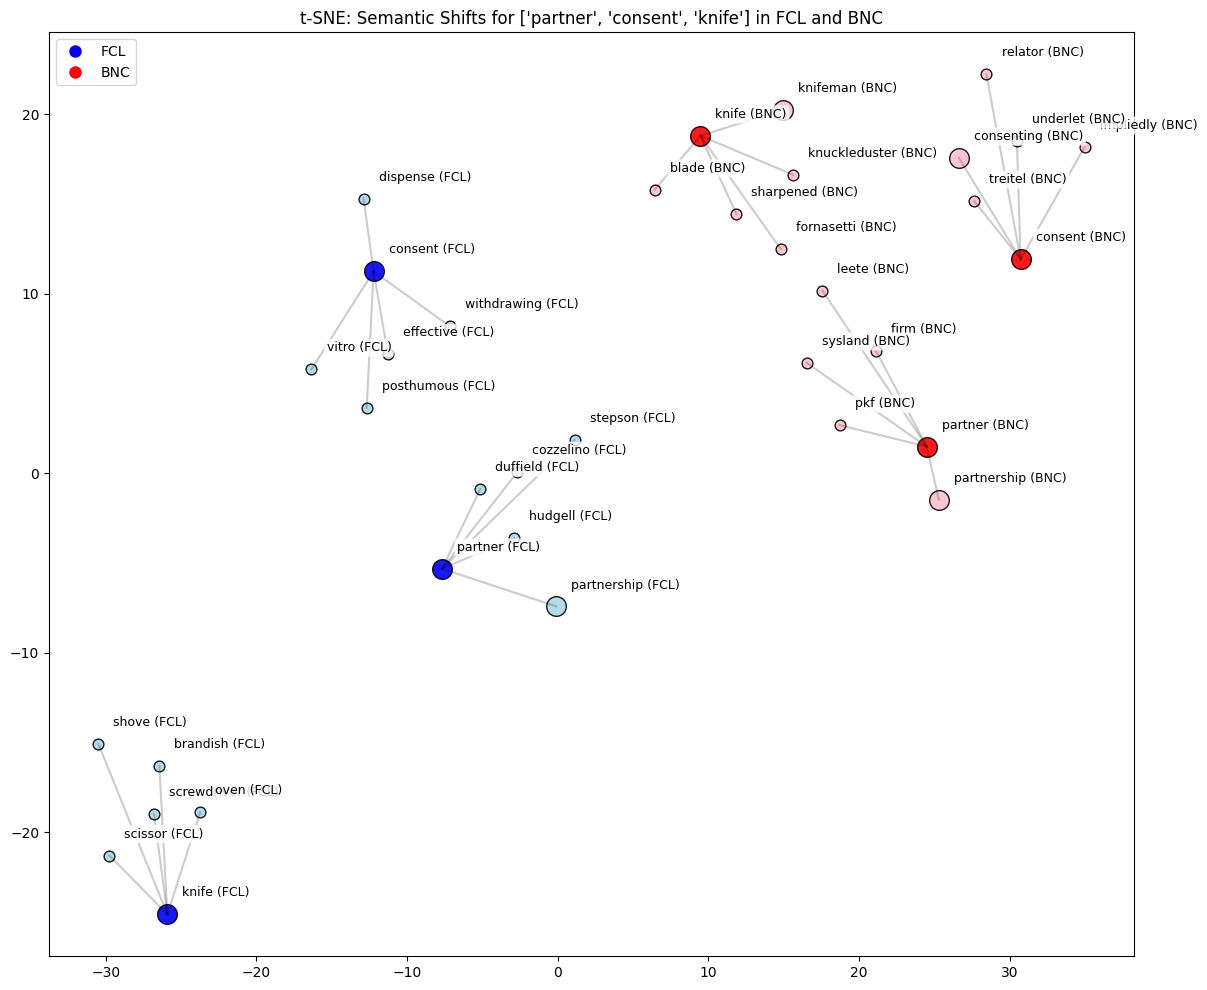

In [13]:
visualize_multiple_words_shift_simple_colors(
    words_list=["partner", "consent", "knife"],
    model1=best_fcl_model,
    model2=best_bnc_model,
    model1_name="FCL",
    model2_name="BNC",
    topn=5
)